### Formulate your own research question

Does the use of Deep Learning leads to a better prostate tumor grade classification performance than the use of radiomic features combined with traditional Machine learning models?

In [1]:
# Install pyradiomics
!pip install SimpleITK==2.0.0
!git clone https://github.com/AIM-Harvard/pyradiomics.git

fatal: destination path 'pyradiomics' already exists and is not an empty directory.


In [2]:
%cd pyradiomics
!python -m pip install -r requirements.txt
!python setup.py build_ext --inplace

/content/pyradiomics
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:484: UserWarning: Normalizing 'v3.0.1.post15+g2791e23' to '3.0.1.post15+g2791e23'
  warnings.warn(tmpl.format(**locals()))
running build_ext
copying build/lib.linux-x86_64-3.7/radiomics/_cmatrices.cpython-37m-x86_64-linux-gnu.so -> radiomics
copying build/lib.linux-x86_64-3.7/radiomics/_cshape.cpython-37m-x86_64-linux-gnu.so -> radiomics


In [3]:
# Install required packages
!pip install natsort
!pip install pynrrd
!pip install pydicom
!pip install nilearn

  Using cached natsort-8.1.0-py3-none-any.whl (37 kB)


In [4]:
import sys
import os
import logging
import six
from natsort import os_sorted
from radiomics import featureextractor, getFeatureClasses, firstorder, getTestCase, glcm, glrlm, glszm, imageoperations, shape
import radiomics
import numpy as np
import fnmatch
import nrrd
import SimpleITK as sitk
import pandas as pd
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import imageio
from skimage.transform import resize
from skimage.util import montage
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import svm, metrics
import warnings
warnings.simplefilter("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Imagepath is the path where MRI patient images are stored
# maskPath is the path where corresponding tumor ROIs are stored
# clinicalpath is the file containing patient ID/gleason score/ucla (likert score)/PSA level/Tumor target index (ignore)

imagePath = "/content/drive/MyDrive/BMI585/HW3/MR data"
maskPath = "/content/drive/MyDrive/BMI585/HW3/Lesion data"
clinicalpath = "/content/drive/MyDrive/BMI585/HW3/clinicaldata.csv"


# Read in patient ID/gleason score/ucla (likert score)/PSA level/Tumor target index (ignore)
df = pd.read_csv(clinicalpath, delimiter = ',')

# This method takes MRI image path and returns patient ID
def getidfrommr(path):
    return path.split('MR data/')[1].split('.nrrd')[0]

# This method takes segmentation data path and returns patient ID
def getidfromsg(path):
    return path.split('seriesUID-')[1].split('.nrrd')[0]

# This method takes patient ID and returns Gleason score
def getgleasonfromid(id):
   num = df.loc[df['ids'] == id]['gleason'].values.astype(int)
   return num

# This method takes patient ID and returns UCLA Likert score
def getuclafromid(id):
   num = df.loc[df['ids'] == id]['ucla'].values.astype(int)
   return num

# This method takes patient ID and returns PSA levels.
def getpsafromid(id):
   num = df.loc[df['ids'] == id]['PSA'].values
   return num

# This method takes patient ID and returns tumor ROI path
def gettargetnum(id):
    return df.loc[df['ids'] == id]['target'].astype(int)

In [7]:
# Now you need to start organizing the data. You can use os.walk() to find the MRI files and tumor ROI files,
# However, for each patient, you will use the patient ID ( can be found in both excel file and MRI filename and tumor ROI target name)
# And match each MRI file to the correct tumor ROI file.
# You can use any of the previous method to do this.

# Define parent path
parent_path = "/content/drive/MyDrive/BMI585/HW3"

# This stores the tumor ROI file path
each_stl_path = os.listdir("/content/drive/MyDrive/BMI585/HW3/Lesion data")
each_stl_path = [os.path.join(parent_path, "Lesion data", filename) for filename in each_stl_path]
remove_list = ["/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0015-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.121454218101962008114329735960109850564.nrrd",
               "/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0094-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.169475047529410431517891781007357453002.nrrd", 
               "/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0210-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.143690657570946778059683368681025300851.nrrd", 
               "/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0200-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.115887280238168665991035243330276160031.nrrd"]
for item in remove_list:
  each_stl_path.remove(item)
print(each_stl_path)

# This stores the MRI file path
each_MR_path = [os.path.join(parent_path, "MR data", getidfromsg(filename) + ".nrrd") for filename in each_stl_path]
print(each_MR_path)

# This stores the patient ID
patient_idx = [getidfromsg(filename) for filename in each_stl_path]
print(patient_idx)

['/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0012-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.69373117078152247444857424781532924046.nrrd', '/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0001-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.266717969984343981963002258381778490221.nrrd', '/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0174-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.185125595908703547701451003604227827659.nrrd', '/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0051-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.132829050273585721718933391975422977112.nrrd', '/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0005-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.196285102861067055900322921931257124293.nrrd', '/content/drive/MyDrive/BMI585/HW3/Lesion data/Prostate-MRI-US-Biopsy-0109-Target1-seriesUID-1.3.6.1.4.1.14519.5.2.1.186836648238388457337567272088126630244.nrrd', '/content/drive/

### Read and visualize an MRI image (not lesion from one benign tumor, and one malignant tumor (G>= 6)

In [8]:
# Visualize benign tumor
index = each_MR_path.index(os.path.join(parent_path, "MR data", "1.3.6.1.4.1.14519.5.2.1.134581986918909360753889591939462644248.nrrd"))
MRdata, _ = nrrd.read(each_MR_path[index], index_order='C')
print(MRdata.shape)

plt.figure(figsize=(25, 40))
for i in range(MRdata.shape[0]):
  plt.subplot(10,6,i+1)
  plt.imshow(MRdata[i,:,:], cmap="gray")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:
# Visualize malignant tumor
index = each_MR_path.index(os.path.join(parent_path, "MR data", "1.3.6.1.4.1.14519.5.2.1.266717969984343981963002258381778490221.nrrd"))
MRdata, _ = nrrd.read(each_MR_path[index], index_order='C')
print(MRdata.shape)

plt.figure(figsize=(25, 40))
for i in range(MRdata.shape[0]):
  plt.subplot(10,6,i+1)
  plt.imshow(MRdata[i,:,:], cmap="gray")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Extract radiomic features from each patient using Pyradiomics

In [10]:
# Now you can perform feature extraction.
# Make sure each patient id in each_MR_path matches the one in each_stl_path before you perform this step!!!

# datapyr is the pyradiomics folder. You need to locate this on your PC!
datapyr = '/content/pyradiomics'

# params is the file path for the feature extraction template. Please go to this folder and select the corresponding template
# You can choose between exampleMR_3mm.yaml and exampleMR_5mm.yaml
params = os.path.join(datapyr,  'examples', 'exampleSettings', 'exampleMR_3mm.yaml')

# This instantiates the extractor based on your selected template
extractor = featureextractor.RadiomicsFeatureExtractor(params)

# This will print out all the enabled filters and features.
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)

# Create dictionary to store features from each group of tumor grade
features= {}
benign_features = {}
low_grade_features = {}
med_grade_features = {}
high_grade_features = {}


# for loop run through each patient to extract features.
# First, load in the MRI file using sitk.ReadImage. Then load the corresponding mask.
# Then set the mask direction and origin to that of the MR image.
# For each patient, we get the id and use that to get the gleason score/PSA/UCLA Likert score
# Then we classify the patient into corresponding tumor grade.
# Then we extract and store the features as well as PSA and Likert scores in the dictionary.

for i in range(len(each_MR_path)):

    try:
        
        image = sitk.ReadImage(each_MR_path[i])

        mask = sitk.ReadImage(each_stl_path[i])
        mask.SetDirection(image.GetDirection())
        mask.SetOrigin(image.GetOrigin())

        id = getidfrommr(each_MR_path[i])
        gleason = getgleasonfromid(id)
        ucla = getuclafromid(id)
        psa = getpsafromid(id)

        if (gleason == 0).all():
            benign_features[id] = extractor.execute(image, mask)
            benign_features[id]['ucla'] = ucla
            benign_features[id]['PSA'] = psa
        elif (gleason  == 6).all():
            low_grade_features[id] = extractor.execute(image, mask)
            low_grade_features[id]['ucla'] = ucla
            low_grade_features[id]['PSA'] = psa
        elif (gleason == 7).all():
            med_grade_features[id] = extractor.execute(image, mask)
            med_grade_features[id]['ucla'] = ucla
            med_grade_features[id]['PSA'] = psa
        elif (gleason ==  8).all():
            high_grade_features[id] = extractor.execute(image, mask)
            high_grade_features[id]['ucla'] = ucla
            high_grade_features[id]['PSA'] = psa

        print('Done', i)

    except ValueError as e:
        if len(e.args) > 0 and 'Size of the ROI is too small' in e.args[0]:
            pass
        else:
            print(e.args[0])
            raise e

features['Benign features'] = benign_features
features['Low risk features'] = low_grade_features
features['Med risk features'] = med_grade_features
features['High risk features'] = high_grade_features

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': [2, 2, 2], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 5, 'voxelArrayShift': 300}
Enabled filters:
	 {'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4.0, 5.0]}, 'Wavelet': {}}
Enabled features:
	 {'shape': None, 'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': None, 'glszm': None, 'gldm': None}
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9

In [11]:
# Make sure you save the features into either pickle file or csv file
import pickle
feature_filename = os.path.join(parent_path, "pyr_features.pickle")

with open(feature_filename,'wb') as pickle_file:
    pickle.dump(features, pickle_file)

### Perform feature selection using Sklearn



In [12]:
# Move on to feature selection and classification

# Organize features
features_list = []

for grade in features:
  for patient in features[grade]:
    feat_list = []
    for feature in features[grade][patient]:
      if type(features[grade][patient][feature]) == np.ndarray:
        feat_list.append(features[grade][patient][feature].item())
      else:
        feat_list.append(features[grade][patient][feature])
    if grade == 'Benign features':
      feat_list.append(0)
    elif grade == 'Low risk features':
      feat_list.append(1)
    elif grade == 'Med risk features':
      feat_list.append(2)
    else:
      feat_list.append(3)
    feat_list = feat_list[37:]
    features_list.append(feat_list)

features_names = list(benign_features['1.3.6.1.4.1.14519.5.2.1.134581986918909360753889591939462644248'].keys())[37:]
features_names.append("Label")

In [13]:
# Organize features in df
data = pd.DataFrame(np.array(features_list), columns=features_names)
data = shuffle(data)
data = data.reset_index(drop=True)

# Create dataset
X = data.drop(data.iloc[:, [-1]], axis=1) # Discard the class
X = StandardScaler().fit_transform(X) # Data Standardization
y = data.iloc[:, [-1]]
feature_names = data.columns[:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number of datapoints (patients): {}".format(X.shape[0]))
print("Training data points: {}".format(X_train.shape[0]))
print("Testing data points: {}".format(X_test.shape[0]))
print("Number of features (radiomic): {}".format(X.shape[1]))

Number of datapoints (patients): 176
Training data points: 140
Testing data points: 36
Number of features (radiomic): 1134


In [14]:
# Clean dataset

for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    if np.isnan(X_train[i][j]):
      X_train[i][j] = 0

for i in range(X_test.shape[0]):
  for j in range(X_test.shape[1]):
    if np.isnan(X_test[i][j]):
      X_test[i][j] = 0

In [15]:
# Features Selection with LASSO

# Select best regularization parameter

est = LogisticRegression(penalty="l1", dual=False, solver="liblinear")
#est = LinearSVC(penalty="l1", dual=False)
c_grid = {'C': np.logspace(-3, 1, num=30)}
clf = GridSearchCV(estimator=est, param_grid=c_grid).fit(X_train, y_train)
reg_param = clf.best_params_['C']
print("Regularization parameter: {}".format(reg_param))

# Feature selection
lr_clf = LogisticRegression(C=reg_param, penalty="l1", dual=False, solver="liblinear").fit(X_train, y_train)
#lr_clf = LinearSVC(C=reg_param, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lr_clf, prefit=True)
X_train_reduced = X_train[:, model.get_support()]
X_test_reduced = X_test[:, model.get_support()]
selected_features = model.get_feature_names_out(feature_names)
print("Number of features (after feature selection): {}".format(X_train_reduced.shape[1]))
print("Selected features: {}".format(selected_features))

Regularization parameter: 10.0
Number of features (after feature selection): 234
Selected features: ['original_shape_Elongation' 'original_shape_Flatness'
 'original_shape_Maximum2DDiameterRow' 'original_shape_Sphericity'
 'original_firstorder_InterquartileRange' 'original_firstorder_Kurtosis'
 'original_firstorder_Median' 'original_firstorder_Minimum'
 'original_firstorder_Skewness' 'original_glcm_ClusterShade'
 'original_glcm_DifferenceVariance' 'original_glcm_Imc2'
 'original_glcm_Idm' 'original_glcm_Idmn' 'original_glcm_InverseVariance'
 'original_glrlm_LongRunEmphasis'
 'original_glrlm_LongRunHighGrayLevelEmphasis'
 'original_glrlm_RunVariance'
 'original_glszm_GrayLevelNonUniformityNormalized'
 'original_glszm_LargeAreaHighGrayLevelEmphasis'
 'original_glszm_SmallAreaEmphasis' 'original_gldm_HighGrayLevelEmphasis'
 'original_gldm_LargeDependenceHighGrayLevelEmphasis'
 'log-sigma-2-0-mm-3D_firstorder_90Percentile'
 'log-sigma-2-0-mm-3D_firstorder_InterquartileRange'
 'log-sigma-2-

### Visualize selected features

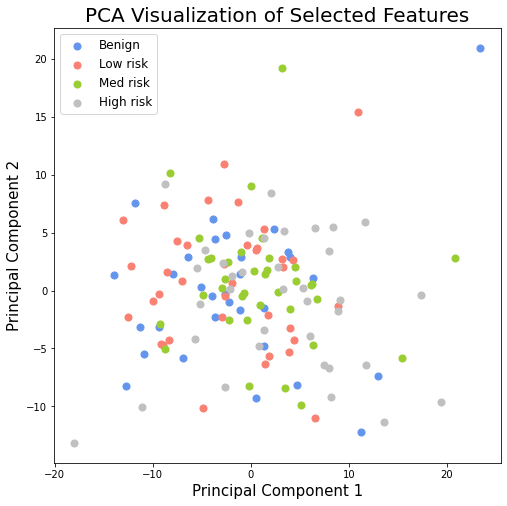

In [16]:
# Visualize features with PCA

principal_comps = PCA(n_components=2).fit_transform(X_train_reduced)
principal_comps_df = pd.DataFrame(data = principal_comps, columns = ['PC1', 'PC2'])
pca_df = pd.concat([principal_comps_df, y_train.reset_index()], axis=1)
pca_df = pca_df[["PC1", "PC2", "Label"]]
pca_df["Label"].replace(0, "Benign", inplace=True)
pca_df["Label"].replace(1, "Low risk", inplace=True)
pca_df["Label"].replace(2, "Med risk", inplace=True)
pca_df["Label"].replace(3, "High risk", inplace=True)

plt.figure(figsize=(8,8))
targets = ["Benign", "Low risk", "Med risk", "High risk"]
colors = ["cornflowerblue", "salmon", "yellowgreen", "silver"]
for target, color in zip(targets, colors):
  indices = pca_df["Label"] == target
  plt.scatter(pca_df.loc[indices, "PC1"], pca_df.loc[indices, "PC2"], c=color, s=50)
plt.xlabel("Principal Component 1", fontsize=15)
plt.ylabel("Principal Component 2", fontsize=15)
plt.title("PCA Visualization of Selected Features", fontsize=20)
plt.legend(targets, fontsize=12)

### Perform classification using ML methods

In [18]:
# Training SVM model

classifier = svm.SVC(kernel="sigmoid", probability=True, random_state=42)
#classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_reduced, y_train)

# Evaluating the model

preds = classifier.predict(X_test_reduced)
print("Accuracy: {}".format(metrics.accuracy_score(y_test, preds)))
print("Precision: {}".format(metrics.precision_score(y_test, preds, average='macro')))
print("Recall: {}".format(metrics.recall_score(y_test, preds, average='macro')))
print("F1-Score: {}".format(metrics.f1_score(y_test, preds, average='macro')))

Accuracy: 0.3888888888888889
Precision: 0.3977022977022977
Recall: 0.4268543956043956
F1-Score: 0.389515455304929


### Implement a DL model to perform the same task

In [19]:
# Try to classify using  Deep Learning

import random
from torch.utils.data import DataLoader
import torch
from torch import nn
import argparse
import math
import os
import random
import numpy as np
from torch.utils.data import Dataset
import torch.nn.functional as F
import nibabel
from scipy import ndimage
import copy
import sklearn
import seaborn as sns

In [20]:
# Create custom dataset

class ProstateDataset(Dataset):

    def __init__(self, img_list, labels_list, masks_list, input_D, input_H, input_W):
        
        self.img_list = img_list
        self.labels_list = labels_list
        self.masks_list = masks_list
        self.input_D = input_D
        self.input_H = input_H
        self.input_W = input_W

    def __nrrd2tensorarray__(self, data):
        [z, y, x] = data.shape
        new_data = np.reshape(data, [1, z, y, x])
        new_data = new_data.astype("float32")
            
        return new_data
    
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        
        # read image
        img_name = self.img_list[idx]
        label = self.labels_list[idx]
        mask_name = self.masks_list[idx]
        img, _ = nrrd.read(img_name, index_order='C')
        mask, _ = nrrd.read(mask_name, index_order='C')
        if label == 0:
          label = 0
        elif label == 6:
          label = 1
        elif label == 7:
          label = 2
        elif label == 8:
          label = 3


        # data processing
        img_array = self.__data_process__(img)

        # 2 tensor array
        img_array = self.__nrrd2tensorarray__(img_array)

        return img_array, label
            

    def __itensity_normalize_one_volume__(self, volume):
        """
        normalize the itensity of an nd volume based on the mean and std of nonzeor region
        inputs:
            volume: the input nd volume
        outputs:
            out: the normalized nd volume
        """
        
        pixels = volume[volume > 0]
        mean = pixels.mean()
        std  = pixels.std()
        out = (volume - mean)/std
        out_random = np.random.normal(0, 1, size = volume.shape)
        out[volume == 0] = out_random[volume == 0]
        return out

    def __resize_data__(self, data):
        """
        Resize the data to the input size
        """ 
        [depth, height, width] = data.shape
        scale = [self.input_D*1.0/depth, self.input_H*1.0/height, self.input_W*1.0/width]  
        data = ndimage.interpolation.zoom(data, scale, order=0)

        return data


    def __data_process__(self, data): 
        # crop data according net input size
        data = data

        # resize data
        data = self.__resize_data__(data)

        # normalization datas
        data = self.__itensity_normalize_one_volume__(data)

        return data

In [21]:
# Create CNN model

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.Dropout3d(p=0.2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.Dropout3d(p=0.2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.conv4 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.Dropout3d(p=0.2),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        
        self.fc1 = nn.Sequential(
            nn.Linear(196608, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout3d(p=0.3))
        
        self.fc2 = nn.Sequential(
            nn.Linear(128, 4))
        
        self._convolutions = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4)

        self._classifier = nn.Sequential(
            self.fc1,
            self.fc2)
        

    def forward(self, x):
        
        out = self._convolutions(x)
        out = torch.flatten(out, start_dim=1)
        out = self._classifier(out)
        
        return out

In [22]:
# Create function for training

def train_CNN(model, epochs, train_dl, val_dl):

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
  train_loss = []
  test_acc = []
  best_acc = 0.0

  for epoch in range(epochs):
    print('-' * 30)
    print('Epoch {}/{}'.format(epoch+1, epochs))

    model.train()
    epoch_loss = 0.0
    epoch_corrects = 0

    for i, data in enumerate(train_dl):        
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, torch.squeeze(labels))
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * inputs.size(0)
      epoch_corrects += torch.sum(preds == labels.data)

    epoch_loss /= len(train_dl)
    train_loss.append(epoch_loss)
    print('Training loss: {:.4f}'.format(epoch_loss))

    if (epoch+1) % 10 == 0:
      model.eval()
      corrects = 0   

      for i, data in enumerate(val_dl): 
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data).item()
      acc = corrects / len(val_dl)
      test_acc.append(acc)
      print('Validation accuracy: {:.4f}'.format(acc))
      if acc > best_acc:
        best_acc = acc
        best_model_weights = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_weights)
  return model, train_loss, test_acc


In [23]:
# Organize data

masks_dl = set(each_stl_path.copy())
train_masks = set(random.sample(masks_dl, 130))
valtest_masks = masks_dl - train_masks
val_masks = set(random.sample(valtest_masks, 23))
test_masks = valtest_masks - val_masks
train_masks = list(train_masks)
val_masks = list(val_masks)
test_masks = list(test_masks)

train_data = [os.path.join(parent_path, "MR data", getidfromsg(filename) + ".nrrd") for filename in train_masks]
val_data = [os.path.join(parent_path, "MR data", getidfromsg(filename) + ".nrrd") for filename in val_masks]
test_data = [os.path.join(parent_path, "MR data", getidfromsg(filename) + ".nrrd") for filename in test_masks]

patient_idx_train = [getidfromsg(filename) for filename in train_masks]
patient_idx_val = [getidfromsg(filename) for filename in val_masks]
patient_idx_test = [getidfromsg(filename) for filename in test_masks]

train_targets = [getgleasonfromid(id) for id in patient_idx_train]
val_targets = [getgleasonfromid(id) for id in patient_idx_val]
test_targets = [getgleasonfromid(id) for id in patient_idx_test]

In [28]:
# Define parameters

input_D = 60
input_H = 256
input_W = 256
batch_size = 2
num_workers = 4
epochs = 100

In [25]:
# Create Dataloaders

training_dataset = ProstateDataset(train_data, train_targets, train_masks, input_D, input_H, input_W)
validation_dataset = ProstateDataset(val_data, val_targets, val_masks, input_D, input_H, input_W)
testing_dataset = ProstateDataset(test_data, test_targets, test_masks, input_D, input_H, input_W)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [26]:
# Checking the datasets

# Training dataset 
for images, labels in training_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('Train set has', training_dataset.__len__(), 'instances.')

# Validation dataset 
for images, labels in validation_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('Train set has', validation_dataset.__len__(), 'instances.')

# Testing dataset 
for images, labels in testing_dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
print('Train set has', testing_dataset.__len__(), 'instances.')

Image batch dimensions: torch.Size([2, 1, 60, 256, 256])
Image label dimensions: torch.Size([2])
Train set has 130 instances.
Image batch dimensions: torch.Size([2, 1, 60, 256, 256])
Image label dimensions: torch.Size([2])
Train set has 23 instances.
Image batch dimensions: torch.Size([2, 1, 60, 256, 256])
Image label dimensions: torch.Size([2])
Train set has 23 instances.


In [29]:
# Train model:

torch.manual_seed(0)
np.random.seed(0)
model = CNN()
model, loss, acc = train_CNN(model, epochs, training_dataloader, validation_dataloader)

------------------------------
Epoch 1/100
Training loss: 3.0326
------------------------------
Epoch 2/100
Training loss: 2.9213
------------------------------
Epoch 3/100
Training loss: 2.8401
------------------------------
Epoch 4/100
Training loss: 2.8088
------------------------------
Epoch 5/100
Training loss: 2.8336
------------------------------
Epoch 6/100
Training loss: 2.9257
------------------------------
Epoch 7/100
Training loss: 2.9825
------------------------------
Epoch 8/100
Training loss: 2.8468
------------------------------
Epoch 9/100
Training loss: 2.8995
------------------------------
Epoch 10/100
Training loss: 2.7951
Validation accuracy: 0.3333
------------------------------
Epoch 11/100
Training loss: 2.7589
------------------------------
Epoch 12/100
Training loss: 2.7657
------------------------------
Epoch 13/100
Training loss: 2.8653
------------------------------
Epoch 14/100
Training loss: 2.7923
------------------------------
Epoch 15/100
Training loss

In [30]:
# Visualize model

model

CNN(
  (conv1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout3d(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout3d(p=0.2, inplace=False)
    (3): ReLU()
    (4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv3d(128, 256, kern

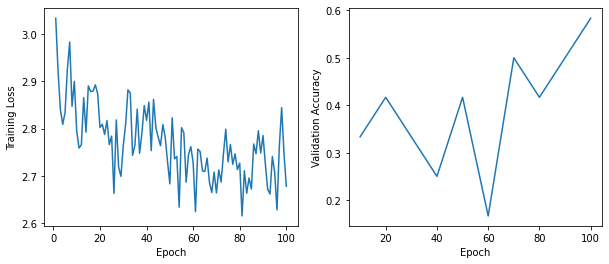

In [31]:
# Visualize training process

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(list(range(1, epochs+1)), loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.subplot(1, 2, 2)
plt.plot(list(np.arange(10, epochs+1,10)), acc)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.show()

Testing Accuracy: 0.5000
Recall: 0.2153
Precision: 0.1528
f1: 0.1667


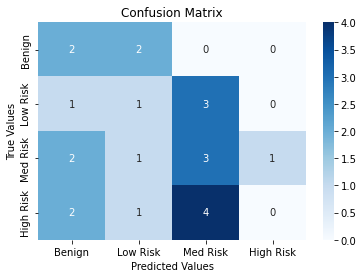

In [32]:
# Test the model

model.eval() 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

acc = 0.0  
recall = 0.0
precision = 0.0
f1 = 0.0
confusion = np.zeros((4, 4))

for i, data in enumerate(testing_dataloader): 
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  acc += torch.sum(preds == labels.data).item()
  predictions = preds.data.cpu().numpy()
  targets = labels.data.cpu().numpy()
  recall += sklearn.metrics.recall_score(targets.flatten(), predictions.flatten(),
                                          average="macro", zero_division=0)
  precision += sklearn.metrics.precision_score(targets.flatten(), predictions.flatten(),
                                                average="macro", zero_division=0)
  f1 += sklearn.metrics.f1_score(targets.flatten(), predictions.flatten(),
                                  average="macro", zero_division=0)
  for j in range(len(inputs)):
      confusion[targets[j], predictions[j]] += 1

print('Testing Accuracy: {:.4f}'.format(acc / len(testing_dataloader)))
print('Recall: {:.4f}'.format(recall / len(testing_dataloader)))
print('Precision: {:.4f}'.format(precision / len(testing_dataloader)))
print('f1: {:.4f}'.format(f1 / len(testing_dataloader)))

# Confusion matrix
ax = sns.heatmap(confusion, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values');
ax.xaxis.set_ticklabels(['Benign','Low Risk', 'Med Risk', 'High Risk'])
ax.yaxis.set_ticklabels(['Benign','Low Risk', 'Med Risk', 'High Risk'])
plt.show()

### Analyze and explain the performance of your model

**Performance of radiomic features and SVM:** Although the feature selection step helped to increase the accuracy, and the other evaluation metrics, the overall performance is unsatisfactory. From the visualization of the selected features in the scatterplot, it was evident that basically any ML model would perform poorly given that you cannot distinguish any of the classes in the plot. However, the accuracy is still greater than the guessing level, which in this problem would be 25%, considering that we have 4 classes. Perhaps, a more careful selection of the radiomic features to extract from the images based on previous knowledge, and a more careful feature selection process could have improved the performance. Also, the training and testing datasets were created by randomly splitting the original dataset. Thus, it would also be worth experimenting with the addition of a step to balance the classes in the pipeline.

**Performance of the Deep Learning model:** For the Deep Learning model, I created a simple model with a low number of layers. The reason for this was the number of datapoints that we have for this problem, which is very small, and it is widely known that Deep Learning models are data hungry. In the training loss plot, we can see that the trend is to decrease along the numbers of epochs. This would be the expected behavior. However, this learning process is very unstable and slow. Besides, starting from epoch 60, it seems like the model reached a plateau and is not learning anymore. Looking at the validation accuracy plot, we can see an increasing trend, which is also the expected behavior. Perhaps, training the model for more epochs would help us visualize better the training process. If we look at the accuracy, it looks like we got a better result than the one we got using the radiomic features with the SVM. However, the other evaluation metrics indicate an extremely poor performance. Lastly, in the confusion matrix we can observe that the model is classifying most of the tumors as med risk. 

**Research Question**: As stated above, if we only took into consideration the accuracy, we would say that the Deep Learning model led to a better performance. However, when analyzing the other evaluation metrics, we can observe that we obtained very poor results for the Deep Learning model. Basically, the performance of both models was highly unsatisfactory. Although there are more things that we could try in an attempt to improve the results, there is a possibility that the obtained results are directly related to the data that we are using. Perhaps, these data is problematic and leads to poor results independently of the model and pipeline used.